In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
import random
from __future__ import division
from sklearn.tree import DecisionTreeClassifier, export_graphviz

In [24]:
carseats = pd.read_csv('data/carseats.csv')
carseats.head()

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No


(array([  6.,  16.,  47.,  83.,  89.,  79.,  40.,  29.,   8.,   3.]),
 array([  0.   ,   1.627,   3.254,   4.881,   6.508,   8.135,   9.762,
         11.389,  13.016,  14.643,  16.27 ]),
 <a list of 10 Patch objects>)

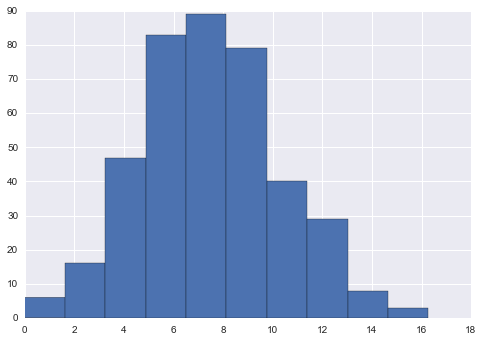

In [6]:
plt.hist(carseats.Sales)

Sales is going to be the response. We'll start by turning it into a binary variable. We'll map sales higher than 8 to True (high Sales)  and lower or equal than 8 to False (low Sales). We will also transform the categorical variables into binary variables and we will use multiple binary columns when there are more than two categories.

In [25]:
y = carseats.Sales > 8 # this is the response variable


carseats.Urban = carseats.Urban == 'Yes' # transform string into boolean variable
carseats.US = carseats.US == 'Yes'

categories = set(list(carseats.ShelveLoc))  # create a set of unique features
# map each category to a different boolean variable
for category in categories:
    carseats['ShelveLoc_is_'+ category.lower()] = carseats.ShelveLoc==category
carseats.head()

features = list(carseats.columns.values)
features = [x for x in features if x !='Sales' and x !='ShelveLoc'] # extract desired features

X  = carseats[features]
X.head()

,CompPrice,Income,Advertising,Population,Price,Age,Education,Urban,US,ShelveLoc_is_bad,ShelveLoc_is_good,ShelveLoc_is_medium
0,138,73,11,276,120,42,17,True,True,True,False,False
1,111,48,16,260,83,65,10,True,True,False,True,False
2,113,35,10,269,80,59,12,True,True,False,False,True
3,117,100,4,466,97,55,14,True,True,False,False,True
4,141,64,3,340,128,38,13,True,False,True,False,False


## Single Tree
We'll start by training a single tree with fixed number of terminal leafs. Then we'll use crossvalidation to train different model complexities (number of terminal leafs) and choose the best one.

In [34]:
# Train the model
i_train = random.sample(range(len(y)), len(y)*4//5)
i_test = list(set(range(len(y)))- set(i_train))
X_train, y_train = X.values[i_train], y[i_train].values
X_test, y_test = X.values[i_test], y[i_test].values
dt = DecisionTreeClassifier(max_leaf_nodes = 10)
dt.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=10, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            random_state=None, splitter='best')

In [36]:
with open('dt_test.dot', 'w') as f:
    export_graphviz(dt,out_file=f,feature_names=features)
!dot -Tpng dt_test.dot -o single_tree.png  
!open single_tree.png

In [17]:
# test error (accuracy)
y_hat = dt.predict(X_test)
print 'Accuracy = {}'.format(sum(y_hat==y_test)/len(y_hat))

Accuracy = 0.7875


In [23]:
# confusion matrix
TP = sum([1 for ori,pred in zip(y_test,y_hat) if ori and pred]) #pythonic version
FN = sum(~pd.TimeSeries(y_hat)&pd.TimeSeries(y_test))
TN = sum(~pd.TimeSeries(y_hat)&~pd.TimeSeries(y_test))
FP = sum(pd.TimeSeries(y_hat)&~pd.TimeSeries(y_test))
np.array([[TP,FP],[FN,TN]])
print 'P\\O  T  F\n T   {},{}\n F   {},{}'.format(TP,FP,FN,TN)

P\O  T  F
 T   16,22
 F   16,26


### Cross-validation: choosing the right number of terminal nodes

In [43]:
from sklearn import cross_validation

X = carseats[features].values #convert to numpy array
kf = cross_validation.KFold(n=len(X), n_folds=5, shuffle=True)
error_rate_leaf = []
n_leaf_list = range(2,20)
for n_leaf in n_leaf_list:
    error_rate_fold = []
    for i_train,i_val in kf:
        X_train, y_train = X[i_train], y[i_train]
        X_val, y_val = X[i_val], y[i_val]
        dt = DecisionTreeClassifier(max_leaf_nodes = n_leaf)
        dt.fit(X_train,y_train)
        
        # Calculate error rate
        y_hat = dt.predict(X_val)
        error_rate_fold.append(sum(y_val != y_hat)/len(y)) # nk cancels out in the formula nk/n ErrorK
    error_rate_leaf.append(sum(error_rate_fold))    

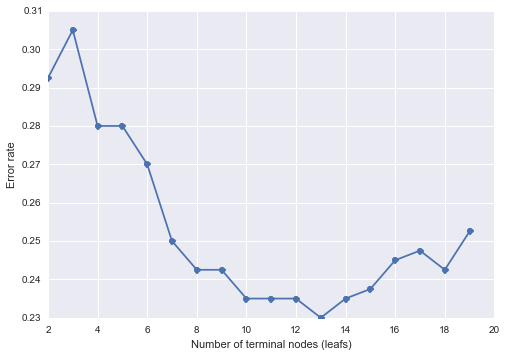

In [46]:
plt.plot(n_leaf_list,error_rate_leaf,'-o')
plt.xlabel('Number of terminal nodes (leafs)')
plt.ylabel('Error rate')

I'll probably would use a tree with aroung 10 terminal nodes. So we could train the tree on the full training data with the choosen complexity.

## Bootstrap aggregation (bagging)
Generate B different bootstrapped training data sets. The prediction of a point x is the average over the B predictions from the B treed. 